# Preliminary CIFAR-10 Analysis

Simple example using CIFAR-10 and a simple fast gradient sign attack.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os

import numpy as np
from scipy.stats import ks_2samp
import pylab as plt
import pandas as pd

from sklearn import svm
from sklearn.metrics import roc_curve, auc


from functools import reduce

In [5]:
df = pd.read_pickle('../cifar10_stats_df.pkl')

print(df.dtypes.index)

datasets = pd.unique(df['Dataset'])
examples = pd.unique(df['Example#'])

print('frame has %d datasets and %d unique examples' % (len(datasets), len(examples)))
print(datasets)

training = np.random.choice(examples, size=int(np.floor(.6*len(examples))))
testing = [x for x in examples if x not in training]

Index(['boundary_distance', 'delta_loss', 'direction_id', 'direction_type',
       'k', 'y', 'y_hat', 'ell2_grad', 'Dataset', 'Example#', 'Approx_conf'],
      dtype='object')
frame has 5 datasets and 1264 unique examples
['cifar10' 'FGM-0.02' 'FGM-0.05' 'FGM-0.10' 'FGM-0.20']


cifar10 has 1264 examples
FGM-0.02 has 656 examples
FGM-0.05 has 1086 examples
FGM-0.10 has 1194 examples
FGM-0.20 has 1215 examples
"cifar10" vs "FGM-0.02" : pvalue=6.22e-102
"cifar10" vs "FGM-0.05" : pvalue=3.1e-30
"cifar10" vs "FGM-0.10" : pvalue=1.05e-07
"cifar10" vs "FGM-0.20" : pvalue=8.5e-30
"FGM-0.02" vs "FGM-0.05" : pvalue=1.1e-35
"FGM-0.02" vs "FGM-0.10" : pvalue=7.06e-62
"FGM-0.02" vs "FGM-0.20" : pvalue=2.15e-34
"FGM-0.05" vs "FGM-0.10" : pvalue=2.03e-11
"FGM-0.05" vs "FGM-0.20" : pvalue=2.19e-05
"FGM-0.10" vs "FGM-0.20" : pvalue=2.4e-09


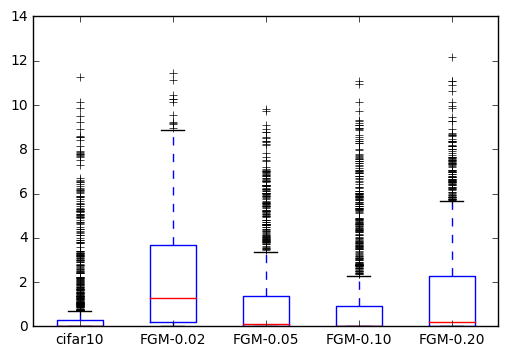

In [12]:
# Here we examine whether the gradient norm seems to be indicative
# of AE vs clean examples.

## Extract the gradient information for each dataset

# only need the rows containing the gradient for this analysis
d_grad = df[df['direction_type'] == 'gradient']

gradient_norms = []
example_id = []
dataset_id = []
for idx, dset in enumerate(datasets):
    rows = (d_grad['Dataset'] == dset)
    n = np.sum(rows)
    print('%s has %d examples' % (dset, n))
    
    gradient_norms.append(d_grad['ell2_grad'][rows])
    example_id.append(d_grad['Example#'][rows])
    dataset_id.append(idx * np.ones((n,)))

    
## visually inspect the distributions
plt.boxplot(gradient_norms, labels=datasets)
plt.plot()

#plt.figure()
#for ii in range(len(gradient_norms)):
#    plt.hist(np.log(gradient_norms[ii]), alpha=0.5, label=datasets[ii])
#plt.legend(loc='upper left')
#plt.show()


## Compare each AE distribution to the clean example distribution with a simple statistical test.

for ii in range(len(datasets)):
    for jj in range(ii+1,len(datasets)):
        comparison = [gradient_norms[ii], gradient_norms[jj]]
        _, pv = ks_2samp(*comparison)
        print('"%s" vs "%s" : pvalue=%0.3g' % (datasets[ii], datasets[jj], pv))


[ True False False False False]
0


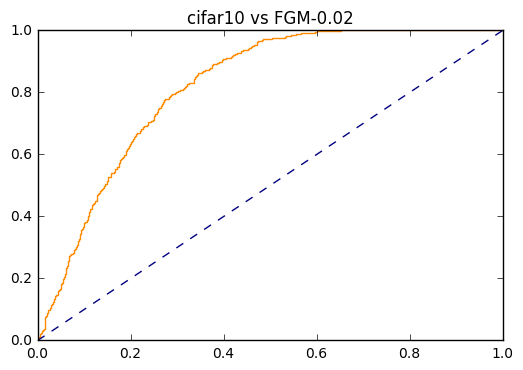

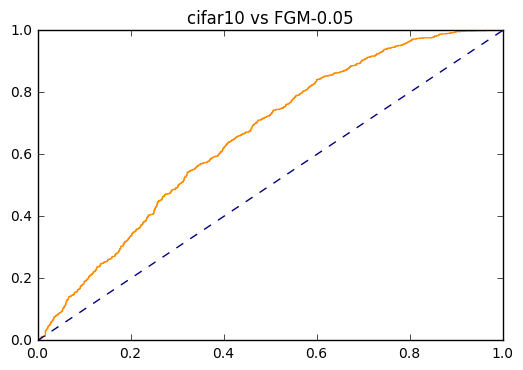

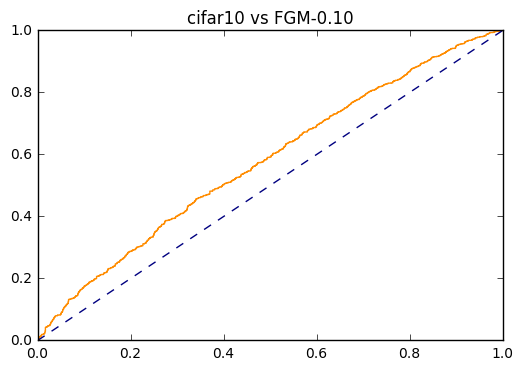

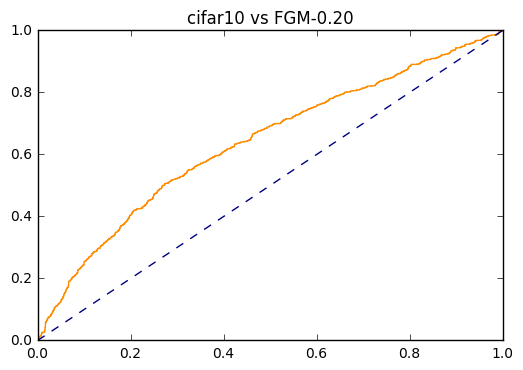

In [22]:
# consider the "classification" performance if we use a single feature, the gradient norm.
print(datasets == 'cifar10')
idx_0 = np.nonzero(datasets == 'cifar10')[0][0]
print(idx_0) # TEMP

for idx_1 in range(len(datasets)):
    if idx_1 == idx_0:
        continue
    
    class_0 = gradient_norms[idx_0]
    class_1 = gradient_norms[idx_1]
    
    y_score = np.concatenate([class_0, class_1], axis=0)
    y_true = np.concatenate([np.zeros((len(class_0),)), np.ones((len(class_1),))])
    
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange')
    plt.plot([0,1], [0,1], color='navy', linestyle='--')
    plt.title('%s vs %s' % (datasets[idx_0], datasets[idx_1]))
    plt.show()